### 1. Import libraries

In [2]:
from ezyrb import POD, RBF, Database
from ezyrb import ReducedOrderModel as ROM

from scipy.interpolate import RBFInterpolator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

import matplotlib.pyplot as plt

from varname import nameof

### 2. Read and preprocess of the data

In [3]:
# Assuming your data preparation steps are done here
num_simulations = 100
train_ratio = 0.8

# Load npy data from training_data folder
pressure_data = np.load('training_data/pressure_data.npy')
velocity_data = np.load('training_data/velocity_data.npy')

# Load design parameters from training_data folder
design_parameters = np.load('training_data/displacement_data.npy')

In [4]:
random_state = 42

# randomly spit the data into training and testing data
train_pressure, test_pressure = train_test_split(pressure_data, train_size=train_ratio, random_state=random_state)
train_velocity, test_velocity = train_test_split(velocity_data, train_size=train_ratio, random_state=random_state)
train_design_parameters, test_design_parameters = train_test_split(design_parameters, train_size=train_ratio, random_state=random_state)

In [5]:
# delete columns with all zeros in train_design_parameters
eliminate_columns = np.all(train_design_parameters == 0, axis=0)
train_design_parameters = train_design_parameters[:, ~eliminate_columns]
test_design_parameters = test_design_parameters[:, ~eliminate_columns]

### 3. POD and plot the truncated energy norm

### 4. RBF to interpolate the parameters

In [74]:
# Define a function to evaluate RBF with different parameters
def evaluate_rbf(x,y):
    # List of kernel functions to test
    kernels = ['linear', 'thin_plate_spline', 'cubic', 'quintic', 'multiquadric', 'inverse_multiquadric', 'gaussian']
    epsilons = np.logspace(-3, 3, 7)

    best_kernel = kernels[0]
    best_epsilon = epsilons[0]
    best_score = float('inf')
    
    for kernel in kernels:
        for epsilon in epsilons:
            # print(f'Kernel: {kernel}, Epsilon: {epsilon}')


            # use try to avoid any errors
            try:
                rbf = RBF(kernel=kernel, epsilon=epsilon)
                rbf.fit(x, y)
                y_pred = rbf.predict(x)

                # Evaluate performance
                score = mean_squared_error(y, y_pred)

                # print(f'kernel: {kernel}, epsilon: {epsilon}, MSE: {score}')
                
                # Update the best kernel if current score is better
                if score < best_score:
                    best_epsilon = epsilon
                    best_kernel = kernel
                    best_score = score
            except:
                # print(f'Error occured with kernel: {kernel}, Epsilon: {epsilon}')   
                continue         

    print(f'Best kernel: {best_kernel}, Best epsilon: {best_epsilon}, Best MSE: {best_score}')
    
    return best_kernel, best_epsilon

In [71]:
def PODI(train_data, test_data, train_design_parameters, test_design_parameters, 
         plot_singular_values=False, epsilon=1e-6):

    pod = POD('svd', rank=1-epsilon)
    pod.fit(train_data)

    print(f'Number of modes: {pod.modes.shape[1]}')

    if plot_singular_values:
         truncated_energy = 1-np.cumsum(np.square(pod.singular_values))/np.sum(np.square(pod.singular_values))
         plt.plot(truncated_energy)
         plt.title('truncated_energy')
         plt.xlabel('Mode')
         plt.ylabel('Relative truncated energy')
         plt.yscale('log')
         plt.show()

    # evaluate the best RBF model
    # Scale the data
    scaler = StandardScaler()
    train_design_parameters_scaled = scaler.fit_transform(train_design_parameters)
    best_kernel, best_epsilon = evaluate_rbf(train_design_parameters_scaled, pod.modes)

    # Train the RBF model
    rbf_model = RBF(kernel=best_kernel, epsilon=best_epsilon)

    # try to interpolate the modes_coeffs with the trained RBF model using test_design_parameters
    # loop all test data and calculate the error
    db = Database(train_design_parameters, train_data)
    

    rom = ROM(db, pod, rbf_model)
    rom.fit()

    test_design_parameters_scaled = scaler.transform(test_design_parameters)
    predict = rom.predict(test_design_parameters_scaled)

    # calculate the reconstrcuted error for each test data using mean squared error
    reconstructed_error = np.linalg.norm(test_data - predict.snapshots_matrix, axis=1) / np.linalg.norm(test_data, axis=1)

    # plot the error
    plt.plot(reconstructed_error)
    plt.title('Reconstructed error')
    plt.xlabel('Test data')
    plt.ylabel('Reconstructed error')
    plt.show()

Number of modes: (80, 26)
Best kernel: gaussian, Best epsilon: 10.0, Best MSE: 7.007038643484944e-37


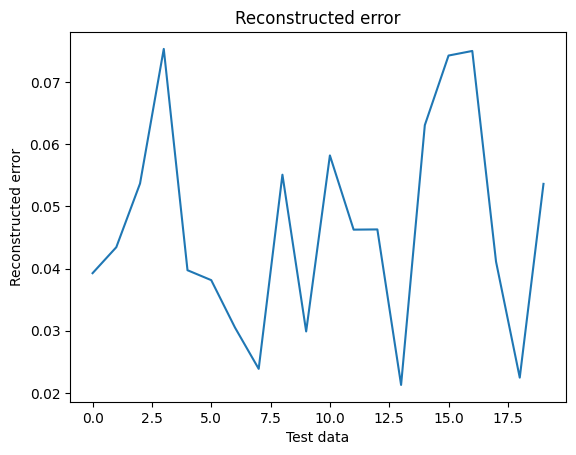

In [75]:
# Perform PODI on the pressure data
PODI(train_pressure, test_pressure, train_design_parameters, test_design_parameters, plot_singular_values=False)

Number of modes: (80, 48)
Best kernel: gaussian, Best epsilon: 10.0, Best MSE: 1.8400902466719862e-36


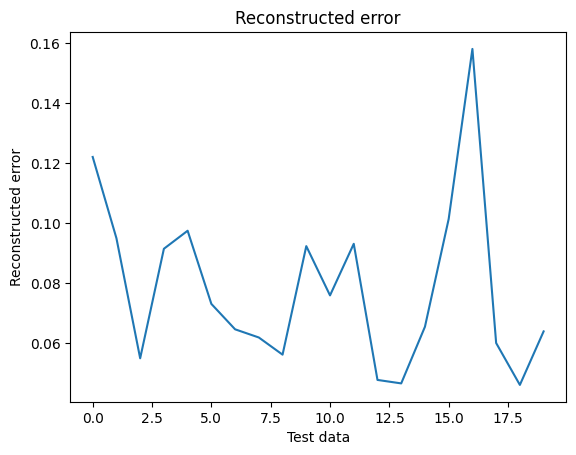

In [76]:
# Perform PODI on the velocity data
PODI(train_velocity, test_velocity, train_design_parameters, test_design_parameters, plot_singular_values=False)